In [1]:
import sys
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib
import sklearn

print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(np.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Scipy: {}'.format(sp.__version__))
print('Seaborn: {}'.format(sns.__version__))
print('Scipy:{}'.format(matplotlib.__version__))
print('Sklearn:{}'.format(sklearn.__version__))


Python: 3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]
Numpy: 1.12.1
Pandas: 0.20.1
Scipy: 1.0.1
Seaborn: 0.7.1
Scipy:2.0.2
Sklearn:0.19.1


In [2]:
import matplotlib.pyplot as plt

In [3]:
#Load the dataset from the csv file
data=pd.read_csv('creditcard.csv')

In [4]:
#Explore the dataset
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [5]:
print(data.shape)

(284807, 31)


In [6]:
print(data.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271e+00  1.23709

## For the 'Class' variable, the mean is close to 0. This means that there are larger number of valid transactions than fraudulent transactions. The dataset is highly unbalanced. 

## I want to use only a fraction of the dataset observations, since the dataset has very large number of rows. So let's sample the dataset.

In [7]:
data=data.sample(frac=0.1,random_state=0)
print(data.shape)

(28481, 31)


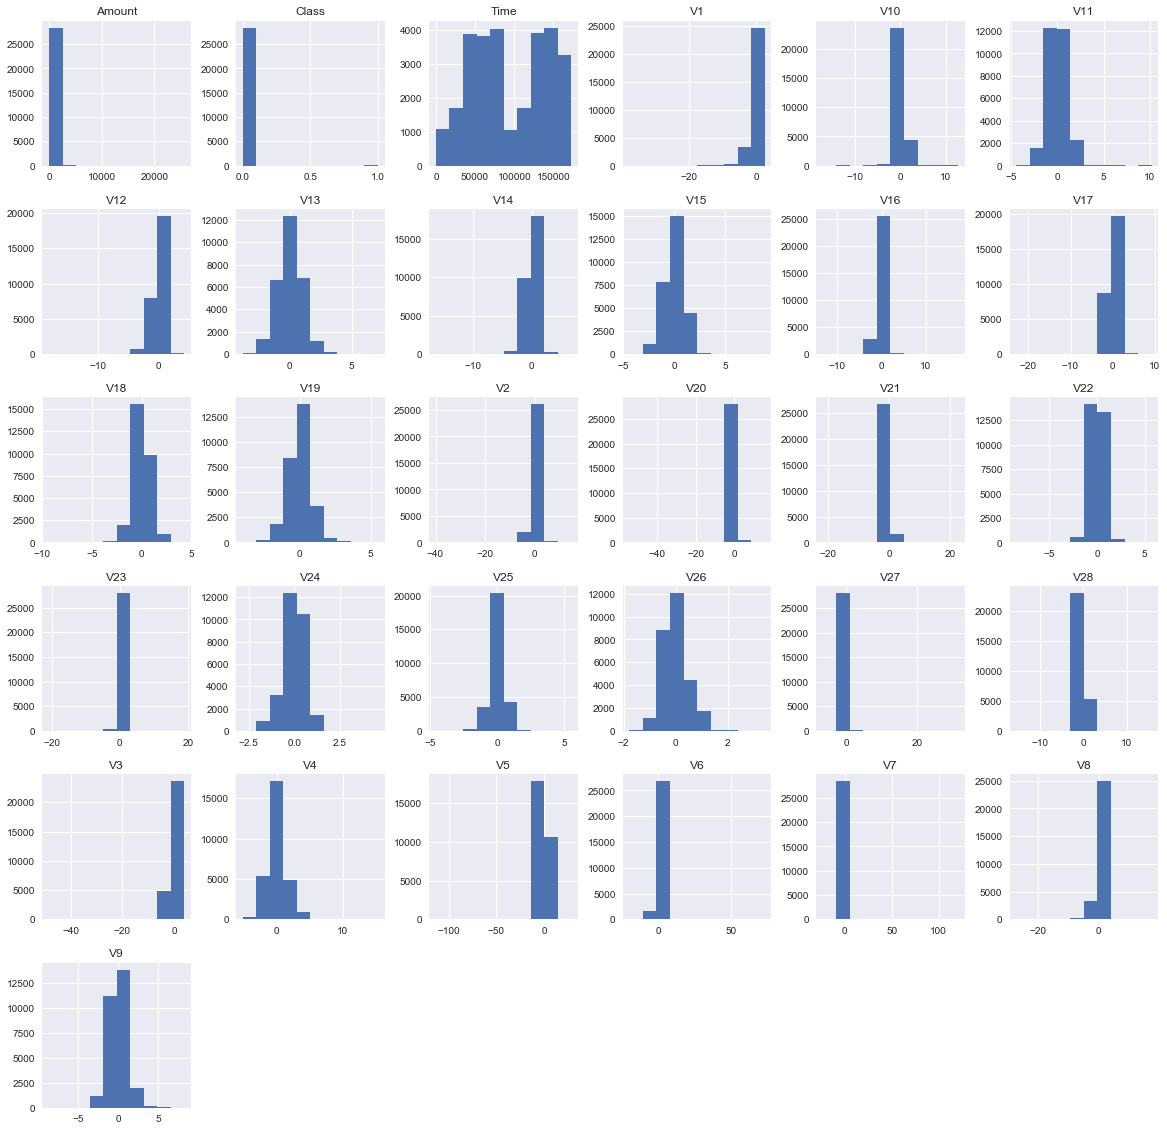

In [8]:
#Plot histogram of each parameter
data.hist(figsize=(20,20))
plt.show()

In [9]:
#Determine number of fraud cases in dataset
Fraud=data[data['Class']==1]
Valid=data[data['Class']==0]
outlier_fraction=len(Fraud)/float(len(Valid))
print(outlier_fraction)
print('Fraud cases:{}'.format(len(Fraud)))
print('Valid cases:{}'.format(len(Valid)))

0.0019348483782452685
Fraud cases:55
Valid cases:28426


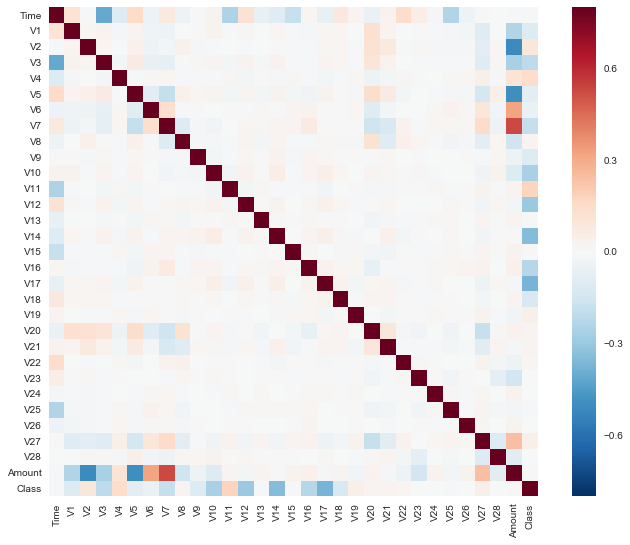

In [10]:
#Correlation Matrix
corrmat=data.corr()
fig=plt.figure(figsize=(12,9))

sns.heatmap(corrmat,vmax=0.8,square=True)
plt.show()

In [11]:
#Get all the columns from the dataframe
columns=data.columns.tolist()

#Filter the columns to remove data we do not want
columns=[c for c in columns if c not in ["Class"]]

#Store the variable we'll be predicting on
target="Class"

X=data[columns]
Y=data[target]

#Print the shapes of X and Y
print(X.shape)
print(Y.shape)


(28481, 30)
(28481,)


In [12]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

#Define a random state
state=1

#define the outlier detection methods
classifiers={
    "Isloation Forest":IsolationForest(max_samples=len(X),contamination=outlier_fraction,
                                      random_state=state),
    "Local Outlier Factor":LocalOutlierFactor(
    n_neighbors=20,contamination=outlier_fraction)
}

In [17]:
#Fit the model
n_outliers=len(Fraud)
for i,(clf_name,clf) in enumerate(classifiers.items()):
    #fit the data and tag outliers
    if clf_name=="Local Outlier Factor":
        y_pred=clf.fit_predict(X)
        scores_pred=clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred=clf.decision_function(X)
        y_pred=clf.predict(X)
    
    #Reshape the prediction values to 0 for valid, 1 for fraud
y_pred[y_pred==1]=0
y_pred[y_pred==-1]=1

n_errors=(y_pred!=Y).sum()

#Run the classification metrics 
print('{}:{}'.format(clf_name,n_errors))
print(accuracy_score(Y,y_pred))
print(classification_report(Y,y_pred))

Local Outlier Factor:109
0.996172887188
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     28426
          1       0.02      0.02      0.02        55

avg / total       1.00      1.00      1.00     28481

